
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
_set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [10]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini")

In [14]:
writer = writer_prompt | llm
# writer = writer_prompt | ChatOllama(
#     # model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=1.2,
# )

In [15]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

《西游记》是中国古典文学中的一部经典之作，讲述了唐僧师徒四人西天取经的传奇故事。为了致敬《水浒传》的风格，我将选取《西游记》中“孙悟空大闹天宫”这一章节进行改写。

---

### 孙猴子大闹天宫

话说那时，天庭之中，众神仙各司其职，正忙着处理天界事务。然则在这安宁的表象之下，暗潮涌动。西天取经的唐僧，正是为此收了个徒弟——猢狲孙悟空。此猴乃是石头崩裂而出，身手矫健，智慧过人，然性情顽劣，心怀不满。昔日，他曾在花果山称王称霸，今日却因受制于师父唐僧，心中不觉愤懑。

一日，孙悟空心中一动，打算去天宫闹个天翻地覆。他一跃而起，化作一阵风，直飞天庭。那天上诸神听闻风声，皆是心惊，纷纷上报玉帝。玉帝闻之，心中大为不安，命下天兵天将，迎战这来历不明的妖猴。

只见孙悟空化作一大金猿，降落在天宫之上，直闯云霄殿，闯入王母娘娘的蟠桃园。那园中桃树，枝繁叶茂，桃花盛开，桃子个个饱满，散发着诱人的香气。孙悟空见状，心中大喜，便飞身摘下几个桃子，畅快地啃了起来，直吃得满脸桃汁，惹得王母娘娘气愤不已。

王母怒火中烧，招来天兵天将，命他们捉拿这妖猴。然而，孙悟空身手不凡，挥舞金箍棒，打得天兵天将们如同落叶一般，纷纷退避。天上神仙见状，纷纷逃散，只剩下那玉帝在高座上脸色苍白，心中暗自叹息。

这时，孙悟空已是意气风发，叫嚷着道：“我乃齐天大圣，何惧你天上的神仙！今日若不让我在此立个威风，你们休想安宁！”说罢，金箍棒一挥，风云骤变，天宫震动不已。

到了最后，玉帝无奈之下，只得请来如来佛祖。佛祖一现身，气势逼人，孙悟空心中一凛，知道这位乃是高人，急忙收起嚣张之气，准备逃跑。然而，如来佛祖只是一掌将其拦住，口中轻声说道：“悟空，若要逃，何不与我一试？”

孙悟空不信，心中轻蔑，便答应了这场较量。两人斗智斗勇，最终孙悟空以为自己逃出了五指山，岂料佛祖的手掌早已将他锁住。无奈之下，孙悟空只得伏低做小，认清自身的渺小。

自此，孙悟空被压在五指山下，心中却是暗自发誓，定要有朝一日翻身做主。天宫虽暂时安宁，但这猴子与天庭之间的恩怨，才刚刚开始。

---

此篇改写试图融入《水浒传》的豪放气概与强烈的个性描写，展现出孙悟空的叛逆与不屈，同时也呼应了《西游记》的主题。希望你喜欢这个风格的改写！如果有任何需要调整或改进的地方，请告诉我。

In [16]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

《西游记》是中国古典文学中的一部经典之作，讲述了唐僧师徒四人西天取经的传奇故事。为了致敬《水浒传》的风格，我将选取《西游记》中“孙悟空大闹天宫”这一章节进行改写。

---

### 孙猴子大闹天宫

话说那时，天庭之中，众神仙各司其职，正忙着处理天界事务。然则在这安宁的表象之下，暗潮涌动。西天取经的唐僧，正是为此收了个徒弟——猢狲孙悟空。此猴乃是石头崩裂而出，身手矫健，智慧过人，然性情顽劣，心怀不满。昔日，他曾在花果山称王称霸，今日却因受制于师父唐僧，心中不觉愤懑。

一日，孙悟空心中一动，打算去天宫闹个天翻地覆。他一跃而起，化作一阵风，直飞天庭。那天上诸神听闻风声，皆是心惊，纷纷上报玉帝。玉帝闻之，心中大为不安，命下天兵天将，迎战这来历不明的妖猴。

只见孙悟空化作一大金猿，降落在天宫之上，直闯云霄殿，闯入王母娘娘的蟠桃园。那园中桃树，枝繁叶茂，桃花盛开，桃子个个饱满，散发着诱人的香气。孙悟空见状，心中大喜，便飞身摘下几个桃子，畅快地啃了起来，直吃得满脸桃汁，惹得王母娘娘气愤不已。

王母怒火中烧，招来天兵天将，命他们捉拿这妖猴。然而，孙悟空身手不凡，挥舞金箍棒，打得天兵天将们如同落叶一般，纷纷退避。天上神仙见状，纷纷逃散，只剩下那玉帝在高座上脸色苍白，心中暗自叹息。

这时，孙悟空已是意气风发，叫嚷着道：“我乃齐天大圣，何惧你天上的神仙！今日若不让我在此立个威风，你们休想安宁！”说罢，金箍棒一挥，风云骤变，天宫震动不已。

到了最后，玉帝无奈之下，只得请来如来佛祖。佛祖一现身，气势逼人，孙悟空心中一凛，知道这位乃是高人，急忙收起嚣张之气，准备逃跑。然而，如来佛祖只是一掌将其拦住，口中轻声说道：“悟空，若要逃，何不与我一试？”

孙悟空不信，心中轻蔑，便答应了这场较量。两人斗智斗勇，最终孙悟空以为自己逃出了五指山，岂料佛祖的手掌早已将他锁住。无奈之下，孙悟空只得伏低做小，认清自身的渺小。

自此，孙悟空被压在五指山下，心中却是暗自发誓，定要有朝一日翻身做主。天宫虽暂时安宁，但这猴子与天庭之间的恩怨，才刚刚开始。

---

此篇改写试图融入《水浒传》的豪放气概与强烈的个性描写，展现出孙悟空的叛逆与不屈，同时也呼应了《西游记》的主题。希望你喜欢这个风格的改写！如果有任何需要调整或改进的地方，请告诉我。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [18]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# reflect = reflection_prompt | ChatOllama(
#     model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=0.2,
# )

reflect = reflection_prompt | llm

In [19]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

感谢您提交的改写文章《孙猴子大闹天宫》。您成功地将《西游记》中经典的“孙悟空大闹天宫”章节融入了《水浒传》的风格，展现了孙悟空的叛逆和个性。以下是我对您作品的详细点评和改进建议：

### 优点：
1. **风格融合**：您成功地将《水浒传》的豪放气概与《西游记》的故事结合，尤其在人物性格的塑造和语言风格上，体现了两者的特色。
2. **情节紧凑**：文章结构清晰，情节发展流畅，能够很好地传达出孙悟空的叛逆精神及与天庭的冲突。
3. **生动描写**：对桃园的描写细腻，生动地展现了场景，能够让读者感受到孙悟空的行为所带来的冲击。

### 改进建议：
1. **字数和长度**：虽然目前的文章较为简洁，但可以考虑增加一些细节和背景信息，以增添文章的深度。例如，可以更详细地描述孙悟空在花果山的生活经历，或者描绘天庭其他神仙的反应，使故事更加丰富。建议字数可以扩展至800-1200字。
  
2. **情感描写**：增强人物内心情感的描写，尤其是孙悟空在面对师父唐僧的压制时的复杂情感，以及他对自由的渴望和对天庭的不满，可以增加文章的情感深度。

3. **语言风格**：在语言上，可以更多地使用《水浒传》中的古典修辞，如对仗和排比，增强文章的文学性。例如，可以尝试在对话中加入一些地方方言或者俚语，使角色更具个性化。

4. **角色对话**：在对话部分可以增加一些神仙与孙悟空之间的对话，增强冲突的戏剧性。例如，王母娘娘的愤怒和天兵天将的无奈都可以通过对话体现出来。

5. **情节延展**：可以考虑延展孙悟空与如来佛祖的对峙，增加斗智斗勇的细节，展现孙悟空的聪明才智与如来佛祖的智慧对抗，增加故事的紧张感。

### 结语：
总体来说，您的文章展现了良好的创作能力和对经典文学的理解。通过上述建议的改进，您可以进一步提升文章的深度与丰富性。我期待看到您更为完善的版本！如果有任何问题或需要进一步的指导，请随时联系我。

In [20]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

感谢您提交的改写文章《孙猴子大闹天宫》。您成功地将《西游记》中经典的“孙悟空大闹天宫”章节融入了《水浒传》的风格，展现了孙悟空的叛逆和个性。以下是我对您作品的详细点评和改进建议：

### 优点：
1. **风格融合**：您成功地将《水浒传》的豪放气概与《西游记》的故事结合，尤其在人物性格的塑造和语言风格上，体现了两者的特色。
2. **情节紧凑**：文章结构清晰，情节发展流畅，能够很好地传达出孙悟空的叛逆精神及与天庭的冲突。
3. **生动描写**：对桃园的描写细腻，生动地展现了场景，能够让读者感受到孙悟空的行为所带来的冲击。

### 改进建议：
1. **字数和长度**：虽然目前的文章较为简洁，但可以考虑增加一些细节和背景信息，以增添文章的深度。例如，可以更详细地描述孙悟空在花果山的生活经历，或者描绘天庭其他神仙的反应，使故事更加丰富。建议字数可以扩展至800-1200字。
  
2. **情感描写**：增强人物内心情感的描写，尤其是孙悟空在面对师父唐僧的压制时的复杂情感，以及他对自由的渴望和对天庭的不满，可以增加文章的情感深度。

3. **语言风格**：在语言上，可以更多地使用《水浒传》中的古典修辞，如对仗和排比，增强文章的文学性。例如，可以尝试在对话中加入一些地方方言或者俚语，使角色更具个性化。

4. **角色对话**：在对话部分可以增加一些神仙与孙悟空之间的对话，增强冲突的戏剧性。例如，王母娘娘的愤怒和天兵天将的无奈都可以通过对话体现出来。

5. **情节延展**：可以考虑延展孙悟空与如来佛祖的对峙，增加斗智斗勇的细节，展现孙悟空的聪明才智与如来佛祖的智慧对抗，增加故事的紧张感。

### 结语：
总体来说，您的文章展现了良好的创作能力和对经典文学的理解。通过上述建议的改进，您可以进一步提升文章的深度与丰富性。我期待看到您更为完善的版本！如果有任何问题或需要进一步的指导，请随时联系我。

In [21]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [22]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [23]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

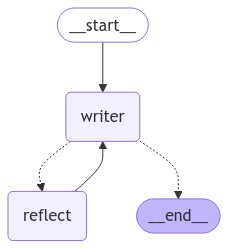

In [24]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [25]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [26]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 尊敬的年轻朋友们：

贫僧今日在此，不禁想起了一段古老的故事。昔日，唐僧师徒四人西行取经，路途艰辛，险象环生，但他们从未退缩，始终朝着目标坚定前行。今日，贫僧愿以此为例，劝勉诸君，努力工作，追求自己的理想。

首先，正如唐僧所言：“路漫漫其修远兮，吾将上下而求索。”人生如同一条漫长的旅途，充满了未知与挑战。在这个飞速发展的时代，年轻人更应当把握时光，勤奋努力，才能在这条路上走得更远。无论是学习知识，提升技能，还是锤炼意志，皆需付出辛勤的汗水，才能收获丰硕的果实。

其次，师徒四人之所以能克服重重困难，皆因心中有信念，有目标。年轻朋友们，立下你们的志向，将梦想化为行动的动力。正如佛法所言：“心即是佛。”唯有心中坚定信念，才能在风雨中不迷失方向。为自己的未来而努力，才能在岁月的长河中，书写出辉煌的篇章。

再者，唐僧常以慈悲为怀，宽容待人。年轻人在职场中，亦应当以谦和之态，待同事如亲，善待每一个人。工作不仅是个人能力的体现，更是团队合作的结晶。与人共事，互助互信，才能在事业的道路上，共同进步，携手并肩，达到更高的境界。

最后，正如孙悟空所说：“一朝一夕，功夫下得多，终有一日展宏图。”年轻人的努力不会被时间辜负，奋斗的每一步，都是为未来铺路。即使遇到荆棘与坎坷，也请不要轻言放弃。唯有坚持不懈，才能迎来那一缕阳光，照亮前行的道路。

年轻的朋友们，愿你们在追求梦想的道路上，心怀信念，脚踏实地，勤奋工作，终能成就一番事业。愿你们的人生如同西天取经之路，虽苦且甘，终获真经。

贫僧在此，寄予厚望。

愿平安顺遂，诸事如意。


## Round 2

#### 评论反思:
- 尊敬的作者，

感谢您提交的文章，您以唐僧的风格写作的尝试是非常有趣且富有创意的。您的文章不仅传达了努力工作的重要性，还通过经典的文学角色引导年轻人树立信念和目标。以下是我对您文章的一些具体反馈和改进建议：

### 1. **内容深度和长短**
- **深度**: 您的文章虽然传达了积极的信息，但在某些部分可以深入探讨。例如，您提到“提升技能”和“锤炼意志”，可以进一步具体化，提供一些具体的例子或建议，比如如何提升技能（参加培训、阅读相关书籍等）或锤炼意志（设定小目标、坚持日常锻炼等）。
- **长度**: 目前的篇幅适中，但可以考虑增加一些段落，尤其是在讲述唐僧师徒克服困难的具体事例时，可以引用更多的经典情节，使文章更具吸引力和说服力。

### 2. **风格和语言**
- **风格**: 您成功地模仿了唐僧的说话风格，使用了古典而优美的语言。但可以适当调整，使其更符合现代年轻人的阅读习惯。可以适当加入一些现代的流行语或比喻，使内容更加贴近年轻人的生活。
- **语言**: 有些句子较为复杂，可能会影响阅读流畅性。建议简化某些句子结构，使其更直接易懂。例如，“无论是学习知识，提升技能，还是锤炼意志，皆需付出辛勤的汗水，”可以简化为“无论是学习、提升技能，还是锤炼意志，都需要付出辛勤的努力。”

### 3. **结构和逻辑**
- **结构**: 您的文章结构清晰，但可以考虑增加小标题，帮助读者更好地把握文章的主旨。例如，可以把每个主要观点单独列为一个小标题，使内容更具条理性。
- **逻辑**: 在某些段落中，论述的逻辑可以更紧密。例如，您提到“工作不仅是个人能力的体现，更是团队合作的结晶”，可以通过举例（如成功团队的案例）来进一步支撑这个观点。

### 4. **总结和呼吁**
- **总结**: 您的结尾部分很有力量，但可以更多地呼应开头，形成完整的闭环。您可以再提及唐僧师徒的精神，以加强文章的整体性。
- **呼吁**: 结尾呼吁年轻人要心怀信念、脚踏实地是很好的，但可以增加一些激励性的语言，比如“让我们一起努力，成为改变世界的力量！”来增强感染力。

### 5. **建议的字数**
- 若您希望进一步扩展文章的深度，可以考虑将字数增加到800-1000字，以便有更多空间进行论述和例证。

总体而言，您的文章展示了良好的写作基础，结合经典文化和现代思考，是一篇富有启发性的作品。希望以上建议对您有所帮助，期待您修改后的新版本！

祝好，

[您的名字]  
[您的职称]


## Round 3

#### 写作生成:
- 尊敬的[您的名字]，

感谢您提供的详细反馈与建议，使我受益匪浅。根据您的意见，我对文章进行了深入的修改与扩展，以使内容更加具体、结构更清晰，并增加了一些现代化的表达方式。以下是修改后的版本：

---

### 努力工作，成就未来

尊敬的年轻朋友们：

贫僧今日在此，想与大家分享一段古老而又充满智慧的故事。昔日，唐僧师徒四人西行取经，路途艰辛，险象环生，但他们从未退缩，始终朝着目标坚定前行。今日，贫僧愿以此为例，劝勉诸君，努力工作，追求自己的理想。

#### 一、坚定信念，勇往直前

正如唐僧所言：“路漫漫其修远兮，吾将上下而求索。”人生如同一条漫长的旅途，充满了未知与挑战。在这个飞速发展的时代，年轻人更应当把握时光，勤奋努力。提升技能是关键，诸君可通过参加培训、阅读相关书籍，甚至利用网络课程来不断充实自己。同时，锤炼意志也不可忽视，设定小目标并坚持日常锻炼，能使你在困难面前更加坚定。

#### 二、设定目标，追逐梦想

师徒四人之所以能克服重重困难，皆因心中有信念，有目标。年轻朋友们，立下你们的志向，将梦想化为行动的动力。正如佛法所言：“心即是佛。”唯有心中坚定信念，才能在风雨中不迷失方向。为自己的未来而努力，才能在岁月的长河中，书写出辉煌的篇章。设定短期和长期目标，逐步实现，才能在实现梦想的路上，保持前行的动力。

#### 三、团队合作，心怀善念

唐僧常以慈悲为怀，宽容待人。年轻人在职场中，亦应当以谦和之态，待同事如亲，善待每一个人。工作不仅是个人能力的体现，更是团队合作的结晶。与人共事，互助互信，才能在事业的道路上，共同进步。以相互支持和合作的心态，创造出更优秀的团队成果。

#### 四、坚持不懈，迎接挑战

正如孙悟空所说：“一朝一夕，功夫下得多，终有一日展宏图。”年轻人的努力不会被时间辜负，奋斗的每一步，都是为未来铺路。即使遇到荆棘与坎坷，也请不要轻言放弃。坚持不懈，才能迎来那一缕阳光，照亮前行的道路。可以借鉴一些成功人士的故事，从他们的经历中汲取力量，激励自己不断前行。

#### 五、总结与呼吁

年轻的朋友们，愿你们在追求梦想的道路上，心怀信念，脚踏实地，勤奋工作，终能成就一番事业。让我们一起努力，成为改变世界的力量。愿你们的人生如同西天取经之路，虽苦且甘，终获真经。

贫僧在此，寄予厚望。

愿平安顺遂，诸事如意。

---

希望以上修改能够更好地传达我想表达的信息。如果您还有其他建议或想法，请随时告诉我，我会继续调整和完善。

祝好，

[您的名字]  
[您的职称]


## Round 4

#### 评论反思:
- 尊敬的作者，

感谢您重新提交修改后的版本，您的努力和认真态度让我印象深刻！文章在内容的深度、结构的清晰度以及现代化表达方面都有了显著的提升。以下是我对您修改后的文章的一些具体反馈和建议：

### 1. **内容丰富性**
- 您在每个小节中增加了具体的建议和方法，例如参加培训和设定小目标，这使得内容更加实用，能更好地引导年轻人如何努力工作。可以考虑在“设定目标，追逐梦想”部分，增加一些具体的目标设定方法（如SMART原则），进一步增强实用性。

### 2. **语言风格**
- 您成功地在保持唐僧风格的基础上加入现代化的表达，使得文章更容易被年轻人接受。可以考虑在某些地方加入更多生动的比喻或例子，使文章更加形象。例如，在谈到“心怀善念”时，可以加入一些实际的职场故事，以增强说服力。

### 3. **结构与逻辑**
- 您的结构清晰，采用了小标题的方式使得阅读流畅，逻辑也更加紧密。可以考虑在每个小节开头增加一个引言句，简短介绍该节目的核心思想，从而使读者更易于抓住重点。

### 4. **总结部分**
- 您的总结部分呼应了开头，形成了良好的闭环。可以考虑更具激励性和号召力的语言，例如“让我们携手并肩，共同创造美好的未来！”来加强结尾部分的感染力。

### 5. **字数建议**
- 文章的字数适中，内容丰富，保持在800-1000字的范围是很合适的。若您希望进一步扩展，可以考虑增加一些经典故事的具体情节，或者添加一些年轻人在工作中遇到的具体挑战与解决方案，以进一步增强文章的深度。

### 6. **整体建议**
- 总体来说，您的文章已经非常出色，传达了积极向上的信息，并且与年轻人的生活紧密相关。建议您在定稿前再进行一次通读，检查是否有语法或拼写错误，并确保每个部分都流畅自然。

期待看到您最终的版本，继续保持这样的创作热情！如果您有任何其他问题或需要进一步的建议，请随时联系我。

祝好，

[您的名字]  
[您的职称]


## Round 5

#### 写作生成:
- 尊敬的[您的名字]，

非常感谢您再次提供的详细反馈和建议，您的支持与鼓励让我倍感振奋。根据您的意见，我进一步对文章进行了增强和细化，尤其是在内容丰富性和语言生动性方面。以下是经过进一步修改的版本：

---

### 努力工作，成就未来

尊敬的年轻朋友们：

贫僧今日在此，想与大家分享一段古老而又充满智慧的故事。昔日，唐僧师徒四人西行取经，路途艰辛，险象环生，但他们从未退缩，始终朝着目标坚定前行。今日，贫僧愿以此为例，劝勉诸君，努力工作，追求自己的理想。

#### 一、坚定信念，勇往直前

正如唐僧所言：“路漫漫其修远兮，吾将上下而求索。”人生如同一条漫长的旅途，充满了未知与挑战。在这个飞速发展的时代，年轻人更应当把握时光，勤奋努力。提升技能是关键，诸君可通过参加培训、阅读相关书籍，甚至利用网络课程来不断充实自己。同时，锤炼意志也不可忽视，设定小目标并坚持日常锻炼，能使你在困难面前更加坚定。

在设定目标时，可以参考SMART原则：确保目标具体、可衡量、可实现、相关性强、时限明确。比如，你可以设定“在三个月内提升英语口语水平，每周至少参加两次语言交流活动”，这样的具体目标将使你的努力更具方向性。

#### 二、设定目标，追逐梦想

师徒四人之所以能克服重重困难，皆因心中有信念，有目标。年轻朋友们，立下你们的志向，将梦想化为行动的动力。正如佛法所言：“心即是佛。”唯有心中坚定信念，才能在风雨中不迷失方向。为自己的未来而努力，才能在岁月的长河中，书写出辉煌的篇章。

在追寻梦想的过程中，记得保持灵活性和适应性。生活中总会有意想不到的挑战与机遇，能够迅速调整自己的方向，或许会让你在变幻的环境中占得先机。

#### 三、团队合作，心怀善念

唐僧常以慈悲为怀，宽容待人。年轻人在职场中，亦应当以谦和之态，待同事如亲，善待每一个人。工作不仅是个人能力的体现，更是团队合作的结晶。与人共事，互助互信，才能在事业的道路上，共同进步。

例如，某公司在一次项目中，团队成员各司其职，积极配合，最终不仅按时完成了任务，还超出了客户的预期。这样的成功正是因为团队成员之间的良好沟通与合作。因此，培养良好的团队意识和沟通能力，将使你在职场中如鱼得水。

#### 四、坚持不懈，迎接挑战

正如孙悟空所说：“一朝一夕，功夫下得多，终有一日展宏图。”年轻人的努力不会被时间辜负，奋斗的每一步，都是为未来铺路。即使遇到荆棘与坎坷，也请不要轻言放弃。坚持不懈，才能迎来那一缕阳光，照亮前行的道路。可以借鉴一些成功人士的故事，从他们的经历中汲取力量，激励自己不断前行。

在这个过程中，记得给自己设定阶段性的奖赏。当你完成某个小目标时，不妨犒劳一下自己，给予自己正向的反馈，这将大大增强你的动力与信心。

#### 五、总结与呼吁

年轻的朋友们，愿你们在追求梦想的道路上，心怀信念，脚踏实地，勤奋工作，终能成就一番事业。让我们携手并肩，共同创造美好的未来。愿你们的人生如同西天取经之路，虽苦且甘，终获真经。

贫僧在此，寄予厚望。

愿平安顺遂，诸事如意。

---

我希望这次的修改能更好地传达出我想要表达的内容。如果您还有其他建议或想法，请随时告诉我，我会继续调整和完善。

再次感谢您的指导与支持！

祝好，

[您的名字]  
[您的职称]


## Round 6

#### 评论反思:
- 尊敬的作者，

感谢您再次提交经过进一步修改的版本！您在内容丰富性和语言生动性方面的努力非常显著，文章在结构和表达上都有了很大的提升。以下是我对您最新版本的一些具体反馈和建议：

### 1. **内容的深度与实用性**
- 您在“坚定信念，勇往直前”部分引入了SMART原则，这为年轻人设定目标提供了具体的指导，非常实用。同时，您提到的“在三个月内提升英语口语水平”这个例子也很好地体现了目标的具体性。可以考虑在其他部分也加入类似的具体实例，使内容更加丰富。

### 2. **语言的生动性**
- 您的语言风格在保留唐僧的古典韵味的同时，增添了现代的表达方式，使文章更加贴近年轻人的口味。例如，在“团队合作，心怀善念”部分使用了实际的公司案例，增强了说服力。您可以考虑在“坚持不懈，迎接挑战”部分也加入一两个成功人士的具体例子，这样会使您的论点更加有力。

### 3. **结构与逻辑**
- 文章的结构清晰且逻辑性强，各部分之间的过渡自然流畅。您在每个小节开头都设置了引导句，进一步增强了文章的可读性。建议在每个小节的结尾增加一个小结，强调该小节的核心观点，帮助读者更好地记忆和吸收。

### 4. **总结的力量**
- 您在总结部分不仅呼应了开头，还用“携手并肩，共同创造美好的未来”这样积极向上的语言增强了激励性。可以考虑在结尾中加入一句鼓励年轻人勇于追梦的话，如“在追梦的路上，唯有奋斗才能开创辉煌的明天”，以加强情感上的共鸣。

### 5. **风格的一致性**
- 您在文章中保持了唐僧特有的慈悲心态和哲理思考，这为文章增添了深度。建议您在每个部分中保持这种风格的一致性，以确保整篇文章在语气和情感上保持和谐。

### 6. **总体建议**
- 整体而言，您的文章已经非常出色，内容丰富、结构合理且具有启发性。再次检查语法、拼写和标点，确保每个句子都流畅自然。在定稿之前，您可以考虑让一些年轻读者先阅读，获取他们的反馈，以便进一步优化。

期待看到您最终的版本，您已经做得非常好了！如果您有其他问题或需要进一步的建议，请随时与我联系。

祝好，

[您的名字]  
[您的职称]


## Round 7

#### 写作生成:
- 尊敬的[您的名字]，

非常感谢您再次给予的详细反馈和鼓励，您的建议使我在修改和提升文章的过程中更有方向感。我将根据您的意见进一步完善文章，特别是在内容的深度、实例的丰富性和总结的力量上。以下是经过进一步修改的版本：

---

### 努力工作，成就未来

尊敬的年轻朋友们：

贫僧今日在此，想与大家分享一段古老而又充满智慧的故事。昔日，唐僧师徒四人西行取经，路途艰辛，险象环生，但他们从未退缩，始终朝着目标坚定前行。今日，贫僧愿以此为例，劝勉诸君，努力工作，追求自己的理想。

#### 一、坚定信念，勇往直前

正如唐僧所言：“路漫漫其修远兮，吾将上下而求索。”人生如同一条漫长的旅途，充满了未知与挑战。在这个飞速发展的时代，年轻人更应当把握时光，勤奋努力。提升技能是关键，诸君可通过参加培训、阅读相关书籍，甚至利用网络课程来不断充实自己。同时，锤炼意志也不可忽视，设定小目标并坚持日常锻炼，能使你在困难面前更加坚定。

在设定目标时，可以参考SMART原则：确保目标具体、可衡量、可实现、相关性强、时限明确。例如，“在三个月内提升英语口语水平，每周至少参加两次语言交流活动”，这样的具体目标将使你的努力更具方向性。若想提升编程能力，可以设定“在六个月内完成一个个人项目，并向朋友展示”，这样清晰的目标会让你更有动力。

#### 二、设定目标，追逐梦想

师徒四人之所以能克服重重困难，皆因心中有信念，有目标。年轻朋友们，立下你们的志向，将梦想化为行动的动力。正如佛法所言：“心即是佛。”唯有心中坚定信念，才能在风雨中不迷失方向。为自己的未来而努力，才能在岁月的长河中，书写出辉煌的篇章。

在追寻梦想的过程中，保持灵活性与适应性也至关重要。生活中总会有意想不到的挑战与机遇，能够迅速调整自己的方向，或许会让你在变幻的环境中占得先机。若遇到挫折，切记这是成长的一部分，正如唐僧在取经路上遇到的重重磨难，最终都化为他成长的养分。

#### 三、团队合作，心怀善念

唐僧常以慈悲为怀，宽容待人。年轻人在职场中，亦应当以谦和之态，待同事如亲，善待每一个人。工作不仅是个人能力的体现，更是团队合作的结晶。与人共事，互助互信，才能在事业的道路上，共同进步。

例如，某公司在一次项目中，团队成员各司其职，积极配合，最终不仅按时完成了任务，还超出了客户的预期。这样的成功正是因为团队成员之间的良好沟通与合作。因此，培养良好的团队意识和沟通能力，将使你在职场中如鱼得水。

#### 四、坚持不懈，迎接挑战

正如孙悟空所说：“一朝一夕，功夫下得多，终有一日展宏图。”年轻人的努力不会被时间辜负，奋斗的每一步，都是为未来铺路。即使遇到荆棘与坎坷，也请不要轻言放弃。坚持不懈，才能迎来那一缕阳光，照亮前行的道路。

在这个过程中，借鉴成功人士的故事会大有裨益。例如，某位著名企业家的创业历程充满了失败与挫折，但他从未放弃，最终建立了自己的商业帝国。记得给自己设定阶段性的奖赏，当你完成某个小目标时，不妨犒劳一下自己，给予自己正向的反馈，这将大大增强你的动力与信心。

#### 五、总结与呼吁

年轻的朋友们，愿你们在追求梦想的道路上，心怀信念，脚踏实地，勤奋工作，终能成就一番事业。在追梦的路上，唯有奋斗才能开创辉煌的明天。让我们携手并肩，共同创造美好的未来。愿你们的人生如同西天取经之路，虽苦且甘，终获真经。

贫僧在此，寄予厚望。

愿平安顺遂，诸事如意。

---

希望这次的修改能够更好地传达出我想要表达的信息。如果您还有其他建议或想法，请随时告诉我，我会继续调整和完善。

再次感谢您的指导与支持！

祝好，

[您的名字]  
[您的职称]


In [27]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 8

#### 写作生成:
- 尊敬的年轻朋友们：

贫僧今日在此，特意想与诸君聊一聊人生大事，乃是结婚与置业。昔日唐僧师徒四人，历经千辛万苦，终得真经，皆因心中有目标，同行有伴。而今，贫僧希望诸位年轻人也能早日成家立业，共创美好未来。

### 一、结婚乃人之常情

正如佛法所言：“人之初，性本善。”人与人之间的情感联系，乃是自然之道。结婚，既是对彼此的承诺，也是对未来的展望。年轻朋友们，良缘天注定，寻得知心人，携手共度人生风雨，实乃人生一大幸事。婚姻不仅是两人的结合，更是家庭与家庭之间的融合，亲情、友情在此交汇，成为人生旅途中的坚实依靠。

### 二、共同奋斗，共创未来

结婚后，夫妻二人可同心协力，携手共进。正如唐僧与孙悟空、猪八戒、沙僧，四人各展所长，互助互信，方能克服种种困难，达成取经之志。同样，年轻夫妻在事业与生活中，若能相互扶持，共同奋斗，定会在艰辛的岁月中，收获丰硕的果实。

在此，贫僧劝勉诸君，切勿因眼前的琐事而心生烦恼。夫妻之间应以理解与包容为本，共同面对生活的挑战，才能在风雨中迎来彩虹，收获幸福的明天。

### 三、置业安家，根基稳固

如同唐僧需在西天取经之前，安稳自己的心志，年轻朋友们在结婚后，也应当考虑置业之事。安家立业，乃是为未来打下坚实的基础。拥有一个温馨的家，不仅是对自己生活的负责，更是对家庭的关爱。

在选择房产时，贫僧建议诸君要理性看待，量入为出，选择适合自己经济条件的房子。房子虽大，温暖的心才是家之所在。若能在适当的时机，购得一处安居之所，日后生活将更为安稳，子孙也可安心成长。

### 四、珍惜时光，早作打算

人生如白驹过隙，转眼即逝。年轻朋友们，韶华易逝，切勿虚度光阴。结婚与置业，若能早作打算，便能在未来的岁月中，享受更多的宁静与幸福。贫僧常言：“有志者事竟成。”只要心怀梦想，勇敢追求，定能在岁月的洪流中，找到属于自己的那片乐土。

### 五、总结与寄语

亲爱的年轻朋友们，结婚与置业，乃是人生中的重要抉择。愿你们在这条道路上，心怀信念，携手并肩，勇敢追梦。愿你们的生活如同唐僧师徒，历经磨难，终获真经，收获幸福的家庭与和谐美满的生活。

贫僧在此，寄予厚望。

愿诸君早日成家立业，平安喜乐，诸事如意。


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 扩展 Reflection Agent
修改 Reflection Prompt
将 System Prompt 修改为更通用的审阅者角色，具体如下：

In [28]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Submissions may include articles, reports, code snippets, or other forms of content."
            " Offer detailed feedback on clarity, structure, content depth, accuracy, and style, as well as actionable recommendations for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

### 使用扩展的 Reflection Agent 生成代码

In [29]:
# 修改后的通用 Prompt
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Submissions may include articles, reports, code snippets, or other forms of content."
            " Offer detailed feedback on clarity, structure, content depth, accuracy, and style, as well as actionable recommendations for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | llm  # 使用扩展后的 Reflection Agent

# 任务定义：为 GitHubSentinel 增加一个 Webhook 信息渠道
task = HumanMessage(
    content=(
        "为 GitHubSentinel 项目新增一个 Webhook 信息渠道。代码需求如下："
        "\n\n1. 支持配置 Webhook URL 和事件类型；"
        "\n2. 接收 Webhook 数据并解析 JSON 格式；"
        "\n3. 将解析结果写入系统日志；"
        "\n4. 代码应包括必要的注释和文档，便于后续维护。"
    )
)

# 调用生成器生成代码
generated_code = ""
for chunk in writer.stream({"messages": [task]}):
    print(chunk.content, end="")
    generated_code += chunk.content

# 显示生成的代码
display(Markdown(f"### 生成的代码:\n```python\n{generated_code}\n```"))

# 使用反思机制对代码进行评估和优化
reflection = ""
for chunk in reflect.stream({"messages": [task, HumanMessage(content=generated_code)]}):
    print(chunk.content, end="")
    reflection += chunk.content

# 显示反思和优化建议
display(Markdown(f"### 优化建议:\n{reflection}"))


为 GitHubSentinel 项目新增一个 Webhook 信息渠道的需求可以通过以下步骤实现。下面的代码示例基于 Python 的 Flask 框架，展示了如何配置 Webhook URL 和事件类型，接收 Webhook 数据，解析 JSON 格式，并将结果写入系统日志。

### 代码实现

首先，确保你已经安装了 Flask。如果尚未安装，可以通过以下命令安装：

```bash
pip install Flask
```

接下来，可以创建一个名为 `webhook_listener.py` 的 Python 文件，并添加以下代码：

```python
from flask import Flask, request, jsonify
import logging
import json

# 创建 Flask 应用
app = Flask(__name__)

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置 Webhook URL 和事件类型（可根据需要进行配置）
WEBHOOK_URL = '/webhook'  # Webhook 的路径
EVENT_TYPE = 'push'  # 需要监听的事件类型

@app.route(WEBHOOK_URL, methods=['POST'])
def handle_webhook():
    """
    处理接收到的 Webhook 请求
    """
    try:
        # 获取 JSON 数据
        data = request.get_json()
        
        # 检查事件类型
        if request.headers.get('X-GitHub-Event') == EVENT_TYPE:
            # 将解析结果写入系统日志
            logging.info("Received event: %s", json.dumps(data, indent=4))
            return jsonify({"status": "s

### 生成的代码:
```python
为 GitHubSentinel 项目新增一个 Webhook 信息渠道的需求可以通过以下步骤实现。下面的代码示例基于 Python 的 Flask 框架，展示了如何配置 Webhook URL 和事件类型，接收 Webhook 数据，解析 JSON 格式，并将结果写入系统日志。

### 代码实现

首先，确保你已经安装了 Flask。如果尚未安装，可以通过以下命令安装：

```bash
pip install Flask
```

接下来，可以创建一个名为 `webhook_listener.py` 的 Python 文件，并添加以下代码：

```python
from flask import Flask, request, jsonify
import logging
import json

# 创建 Flask 应用
app = Flask(__name__)

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置 Webhook URL 和事件类型（可根据需要进行配置）
WEBHOOK_URL = '/webhook'  # Webhook 的路径
EVENT_TYPE = 'push'  # 需要监听的事件类型

@app.route(WEBHOOK_URL, methods=['POST'])
def handle_webhook():
    """
    处理接收到的 Webhook 请求
    """
    try:
        # 获取 JSON 数据
        data = request.get_json()
        
        # 检查事件类型
        if request.headers.get('X-GitHub-Event') == EVENT_TYPE:
            # 将解析结果写入系统日志
            logging.info("Received event: %s", json.dumps(data, indent=4))
            return jsonify({"status": "success", "message": "Event received."}), 200
        else:
            logging.warning("Ignored event: %s", request.headers.get('X-GitHub-Event'))
            return jsonify({"status": "ignored", "message": "Event type not handled."}), 200

    except Exception as e:
        logging.error("Error processing webhook: %s", str(e))
        return jsonify({"status": "error", "message": "Failed to process event."}), 400

if __name__ == '__main__':
    # 启动 Flask 应用
    app.run(host='0.0.0.0', port=5000)
```

### 代码说明

1. **Flask 应用**: 创建了一个 Flask 应用，以处理 HTTP POST 请求。
2. **日志配置**: 使用 Python 的 logging 模块记录日志，方便后续维护和调试。
3. **Webhook 路径和事件类型**: 通过常量 `WEBHOOK_URL` 和 `EVENT_TYPE` 配置 Webhook 的路径和需要监听的事件类型。
4. **处理 Webhook 请求**:
   - 通过 `request.get_json()` 获取请求中的 JSON 数据。
   - 检查请求头中的 `X-GitHub-Event` 是否与预设的事件类型匹配。
   - 如果匹配，将解析的 JSON 数据写入日志。
   - 如果事件类型不匹配，记录警告信息。
5. **错误处理**: 在处理请求的过程中，如果发生错误，会记录错误信息并返回相应的 HTTP 状态码。

### 后续维护建议

- **事件类型的扩展**: 可以将事件类型设置为可配置的选项，方便在不同场景下使用。
- **安全性**: 进一步增强安全性，例如验证 GitHub 发来的请求是否有效。
- **测试**: 编写单元测试，以确保 Webhook 功能的稳定性和可靠性。

以上是为 GitHubSentinel 项目新增 Webhook 信息渠道的基本实现。根据实际需求，你可以进一步扩展和修改代码。
```

您的代码实现已经很好地展示了如何为 GitHubSentinel 项目新增一个 Webhook 信息渠道。以下是我对代码的详细评审和改进建议，以帮助您进一步提升代码的质量和可维护性。

### 评审反馈

1. **清晰性和可读性**:
   - 代码整体结构清晰，注释说明了每个部分的功能，使得代码易于理解。
   - 但是，建议在函数和类的文档字符串中添加更具体的信息，例如参数和返回值的说明，以便其他开发者更好地理解这些接口。

2. **配置管理**:
   - 当前的 `WEBHOOK_URL` 和 `EVENT_TYPE` 是硬编码的。如果将这些配置移动到一个配置文件（如 `.env` 文件或 JSON 配置文件），将使得系统更灵活且易于维护。
   - 使用 `os.environ` 或 `configparser` 库来读取配置文件中的参数。

3. **安全性**:
   - 在处理 GitHub Webhook 请求时，建议添加请求有效性的验证步骤，例如使用 GitHub 提供的签名（`X-Hub-Signature`）来确保请求的真实性。这可以防止伪造的请求。

4. **错误处理**:
   - 在 `except` 块中，您记录了错误信息，但没有提供具体的错误类型。这可能会导致调试时缺乏详细信息。建议使用 `logging.exception()` 来捕获完整的异常堆栈信息。

5. **日志管理**:
   - 目前的日志配置使用了 `INFO` 级别。根据实际需求，可以考虑引入不同的日志级别（例如 `DEBUG`, `WARNING`, `ERROR`），并根据环境（开发、测试、生产）来调整日志级别。

6. **返回信息的标准化**:
   - 您的 JSON 响应虽然已经很清晰，但可以考虑使用标准的 HTTP 状态码和错误消息格式，以便于客户端解析和处理。

### 改进建议

以下是一些具体的代码改进建议，您可以考虑实施：

```python
import os
from flask import Flask, request, jsonify
import logging
import json
import hmac
import hashlib

# 创建 Flask 应用
app = Flask(__name__)

# 配

### 优化建议:
您的代码实现已经很好地展示了如何为 GitHubSentinel 项目新增一个 Webhook 信息渠道。以下是我对代码的详细评审和改进建议，以帮助您进一步提升代码的质量和可维护性。

### 评审反馈

1. **清晰性和可读性**:
   - 代码整体结构清晰，注释说明了每个部分的功能，使得代码易于理解。
   - 但是，建议在函数和类的文档字符串中添加更具体的信息，例如参数和返回值的说明，以便其他开发者更好地理解这些接口。

2. **配置管理**:
   - 当前的 `WEBHOOK_URL` 和 `EVENT_TYPE` 是硬编码的。如果将这些配置移动到一个配置文件（如 `.env` 文件或 JSON 配置文件），将使得系统更灵活且易于维护。
   - 使用 `os.environ` 或 `configparser` 库来读取配置文件中的参数。

3. **安全性**:
   - 在处理 GitHub Webhook 请求时，建议添加请求有效性的验证步骤，例如使用 GitHub 提供的签名（`X-Hub-Signature`）来确保请求的真实性。这可以防止伪造的请求。

4. **错误处理**:
   - 在 `except` 块中，您记录了错误信息，但没有提供具体的错误类型。这可能会导致调试时缺乏详细信息。建议使用 `logging.exception()` 来捕获完整的异常堆栈信息。

5. **日志管理**:
   - 目前的日志配置使用了 `INFO` 级别。根据实际需求，可以考虑引入不同的日志级别（例如 `DEBUG`, `WARNING`, `ERROR`），并根据环境（开发、测试、生产）来调整日志级别。

6. **返回信息的标准化**:
   - 您的 JSON 响应虽然已经很清晰，但可以考虑使用标准的 HTTP 状态码和错误消息格式，以便于客户端解析和处理。

### 改进建议

以下是一些具体的代码改进建议，您可以考虑实施：

```python
import os
from flask import Flask, request, jsonify
import logging
import json
import hmac
import hashlib

# 创建 Flask 应用
app = Flask(__name__)

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 设置 Webhook URL 和事件类型（可配置）
WEBHOOK_URL = os.getenv('WEBHOOK_URL', '/webhook')  # 从环境变量获取
EVENT_TYPE = os.getenv('EVENT_TYPE', 'push')  # 从环境变量获取
GITHUB_SECRET = os.getenv('GITHUB_SECRET', '')  # GitHub Webhook 密钥

def verify_signature(data, signature):
    """
    验证 GitHub Webhook 请求的签名
    """
    hash = hmac.new(GITHUB_SECRET.encode(), data, hashlib.sha1)
    return hmac.compare_digest(f'sha1={hash.hexdigest()}', signature)

@app.route(WEBHOOK_URL, methods=['POST'])
def handle_webhook():
    """
    处理接收到的 Webhook 请求
    """
    try:
        # 获取 JSON 数据
        data = request.get_json()
        signature = request.headers.get('X-Hub-Signature')

        # 验证请求的签名
        if not verify_signature(request.data, signature):
            logging.warning("Invalid signature. Ignoring request.")
            return jsonify({"status": "error", "message": "Invalid signature."}), 403

        # 检查事件类型
        if request.headers.get('X-GitHub-Event') == EVENT_TYPE:
            logging.info("Received event: %s", json.dumps(data, indent=4))
            return jsonify({"status": "success", "message": "Event received."}), 200
        else:
            logging.warning("Ignored event: %s", request.headers.get('X-GitHub-Event'))
            return jsonify({"status": "ignored", "message": "Event type not handled."}), 200

    except Exception as e:
        logging.exception("Error processing webhook")  # 捕获完整的异常信息
        return jsonify({"status": "error", "message": "Failed to process event."}), 400

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
```

### 总结

您的代码实现展示了一个良好的基础，但通过实施上述建议，可以使其更具安全性、灵活性和可维护性。确保在部署之前进行适当的测试，并考虑使用 CI/CD 工具以自动化测试和部署流程。希望这些反馈对您有所帮助！

### 

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。